# Handwritten Digit Recognition for MNIST (5)
### Using 5 layer Convolutional Neural Network (CNN) 
### Activation function: RELU  
This is an example of evaluating 5 layer Convolutional Neural Network for Handwritten Digit Recognition. I'm using MNIST dataset to train and test. This model includes 5 layer neural network with ReLU activation function.

In [1]:
# importing needed libraries
%matplotlib inline

import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import tensorflow as tf
import math

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True, reshape=False, validation_size=0)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [3]:
def plot_batch_images(images, labels, predictions = None, count = 100):
    
    plt.rcParams['axes.linewidth'] = 0.5
    count_row_col = np.sqrt(count)

    fig = plt.figure(figsize=(10, 10))
    
    for i in range(count):
        label = labels[i]
        image = images[i].reshape([28,28])
        sub = plt.subplot(count_row_col, count_row_col, i + 1)
        sub.set_xticks(())
        sub.set_yticks(())
        sub.text(1, 1, label, ha='center', va='top', size=8, color="k")
        
        if not(predictions is None):
            pred = predictions[i]
            sub.text(25, 1, pred, ha='center', va='top', size=8, color="r")
        
        sub.imshow(image, cmap=plt.get_cmap('gray_r'))
    
    fig.tight_layout(pad = 0)
    plt.show()

In [4]:
# parameters
BATCH_SIZE = 100
ITERATION_COUNT = 15000
ACCURACY_CHECK = 200

In [5]:
def train_model(mnist_data):
    
    image_width  = 28
    image_height = 28
    
    C0 = 1   # input channel count
    C1 = 4   # convolutional network channel 1 count 
    C2 = 8   # convolutional network channel 2 count
    C3 = 12  # convolutional network channel 3 count
    C4 = 200 # fulley connected layer size
    C5 = 10  # output count (digit count 0 to 9)
    
    # weights
    W1 = tf.Variable(tf.truncated_normal([5, 5, C0, C1], stddev = 0.1)) 
    W2 = tf.Variable(tf.truncated_normal([5, 5, C1, C2], stddev = 0.1))
    W3 = tf.Variable(tf.truncated_normal([4, 4, C2, C3], stddev = 0.1))
    W4 = tf.Variable(tf.truncated_normal([7 * 7 * C3, C4], stddev = 0.1))
    W5 = tf.Variable(tf.truncated_normal([C4, C5], stddev = 0.1))
    
    # biases
    B1 = tf.Variable(tf.ones([C1]) / 10)
    B2 = tf.Variable(tf.ones([C2]) / 10)
    B3 = tf.Variable(tf.ones([C3]) / 10)
    B4 = tf.Variable(tf.ones([C4]) / 10)
    B5 = tf.Variable(tf.ones([C5]) / 10)

    # model
    stride = 1  # output is 28x28
    X   = tf.placeholder(tf.float32, shape=[None, image_width, image_height, C0])
    Y1  = tf.nn.relu(tf.nn.conv2d(X, W1, strides=[1, stride, stride, 1], padding='SAME') + B1)
    stride = 2  # output is 14x14
    Y2 = tf.nn.relu(tf.nn.conv2d(Y1, W2, strides=[1, stride, stride, 1], padding='SAME') + B2)
    stride = 2  # output is 7x7
    Y3 = tf.nn.relu(tf.nn.conv2d(Y2, W3, strides=[1, stride, stride, 1], padding='SAME') + B3)
    
    # reshape the output from the third convolution for the fully connected layer
    YY = tf.reshape(Y3, shape=[-1, 7 * 7 * C3])
    Y4 = tf.nn.relu(tf.matmul(YY, W4) + B4)
    Ylogits = tf.matmul(Y4, W5) + B5
    Y = tf.nn.softmax(Ylogits)
                      
    # paceholder for learing_rate variable
    lr = tf.placeholder(tf.float32)
    
    # placeholder for correct answers
    Y_ = tf.placeholder(tf.float32, [None, C5])
    
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = Ylogits, labels = Y_)
    cross_entropy = tf.reduce_mean(cross_entropy) * 100
    
    # accuracy of the trained model, between 0 (worst) and 1 (best)
    correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # training step, the learning rate is a placeholder
    train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)

    # initialisation
    init = tf.global_variables_initializer()

    # start computation
    sess = tf.Session()
    sess.run(init)
    
    # preparing return values
    counter = 0 
    upper_bound = int(ITERATION_COUNT / ACCURACY_CHECK)
    train_accuracy = np.zeros(upper_bound)
    train_loss = np.zeros(upper_bound)
    test_accuracy = np.zeros(upper_bound)
    test_loss = np.zeros(upper_bound)
    learning_rates = np.zeros(1)
    
    for i in range(ITERATION_COUNT):
        
        # learning rate decay
        max_learning_rate = 0.003
        min_learning_rate = 0.0001
        decay_speed = 2000.0 # 0.003-0.0001-2000=>0.9826 done in 5000 iterations
        learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * math.exp(-i/decay_speed)
        
        # load batch of images and correct answers
        batch_X , batch_Y = mnist_data.train.next_batch(BATCH_SIZE)
        
        # train
        sess.run(train_step, feed_dict = {X: batch_X, Y_: batch_Y, lr: learning_rate})
        
        if i % ACCURACY_CHECK == 0:

            a , c = sess.run([accuracy, cross_entropy], feed_dict = {X: batch_X, Y_: batch_Y})
            train_accuracy[counter] = a
            train_loss[counter] = c
            
            test_data = {X: mnist_data.test.images, Y_: mnist_data.test.labels}
            pred, a , c = sess.run([Y, accuracy, cross_entropy], feed_dict = test_data)
            predictions = tf.argmax(pred,1).eval(session=sess)
            #print('{}- Accuracy: {}, Learning Rate: {}'.format(i, a, learning_rate))
            test_accuracy[counter] = a
            test_loss[counter] = c
            
            counter += 1
    
    learning_rates[0] = learning_rate
    acc = accuracy.eval(session = sess, feed_dict = {X: mnist_data.test.images, Y_: mnist_data.test.labels})
    print('Learning Rate: {}, Accuracy: {}'.format(learning_rate, acc))
    sess.close()
    
    return train_accuracy, train_loss, test_accuracy, test_loss, predictions, learning_rates;

In [6]:
train_accuracy = []
train_loss = []
test_accuracy = []
test_loss = []
predictions = []
learning_rates = []

%time ta, tl, tsa, tsl, preds, lr = train_model(mnist)

train_accuracy.append(ta)
train_loss.append(tl)
test_accuracy.append(tsa)
test_loss.append(tsl)
predictions.append(preds)
learning_rates.append(lr)

acc_check = np.arange(0, len(train_accuracy[0]))

Learning Rate: 0.00010160474684629193, Accuracy: 0.9876002073287964
Wall time: 3min 14s


In [7]:
def plot_performance_chart(X, Ys, legend_labels, label, loc = 'lower right', xmin = None, xmax = None, ymin = None, ymax = None):
    
    COLORS = ['r', 'g', 'b', 'm', 'c', 'y']
    
    if not(Ys is None):
        
        plt.figure(figsize=(10,4))
        
        for i in range(len(legend_labels)):
            plt.plot(X, Ys[i], c = COLORS[i], label = legend_labels[i])
            plt.legend(loc = loc, frameon = True, prop = {'size':7}, title = "Learning Rate")
            
            if not(xmin is None):
                plt.xlim(xmin = xmin, xmax = xmax)
                
            if not(ymin is None):
                plt.ylim(ymin = ymin, ymax = ymax)

        plt.ylabel(label)
        plt.xlabel('Steps')
        plt.show()

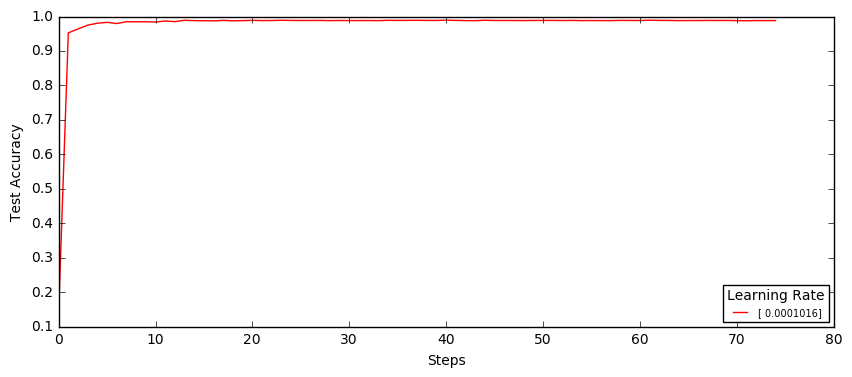

In [8]:
plot_performance_chart(acc_check, test_accuracy, learning_rates, 'Test Accuracy')

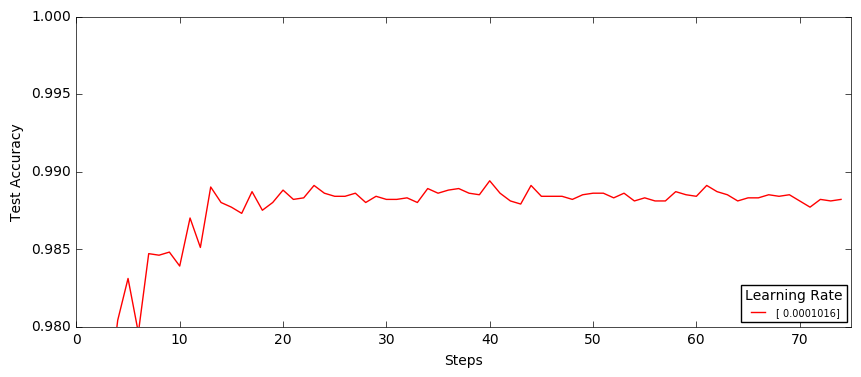

In [15]:
plot_performance_chart(acc_check, test_accuracy, learning_rates, 'Test Accuracy', 
                       xmin = 0, xmax = 75, ymin = 0.98, ymax = 1)

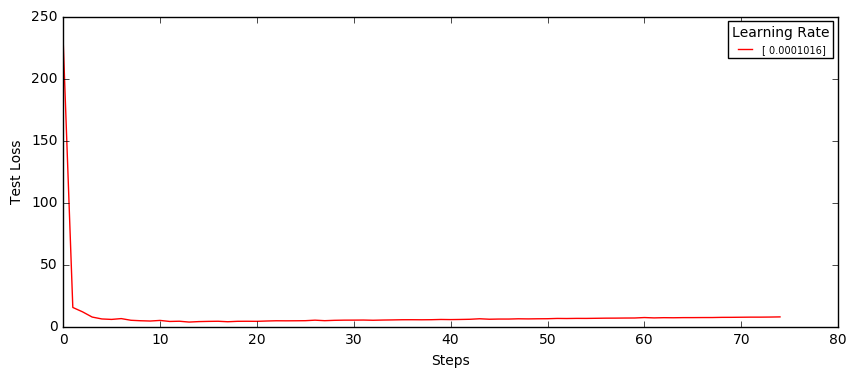

In [10]:
plot_performance_chart(acc_check, test_loss, learning_rates, 'Test Loss', loc = 'upper right')

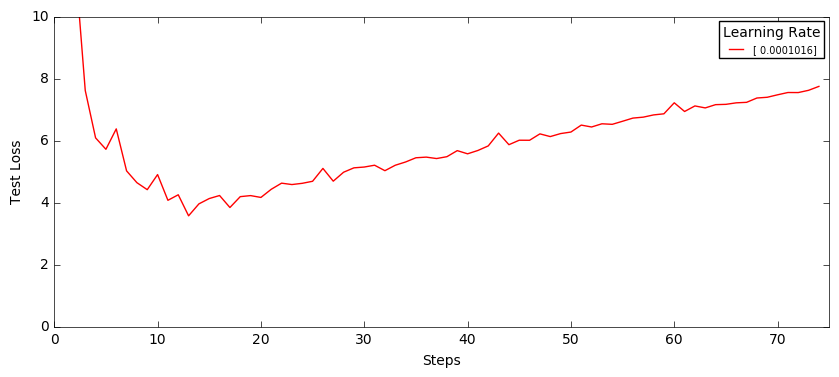

In [16]:
plot_performance_chart(acc_check, test_loss, learning_rates, 'Test Loss', loc = 'upper right',
                       xmin = 0, xmax = 75, ymin = 0, ymax = 10)

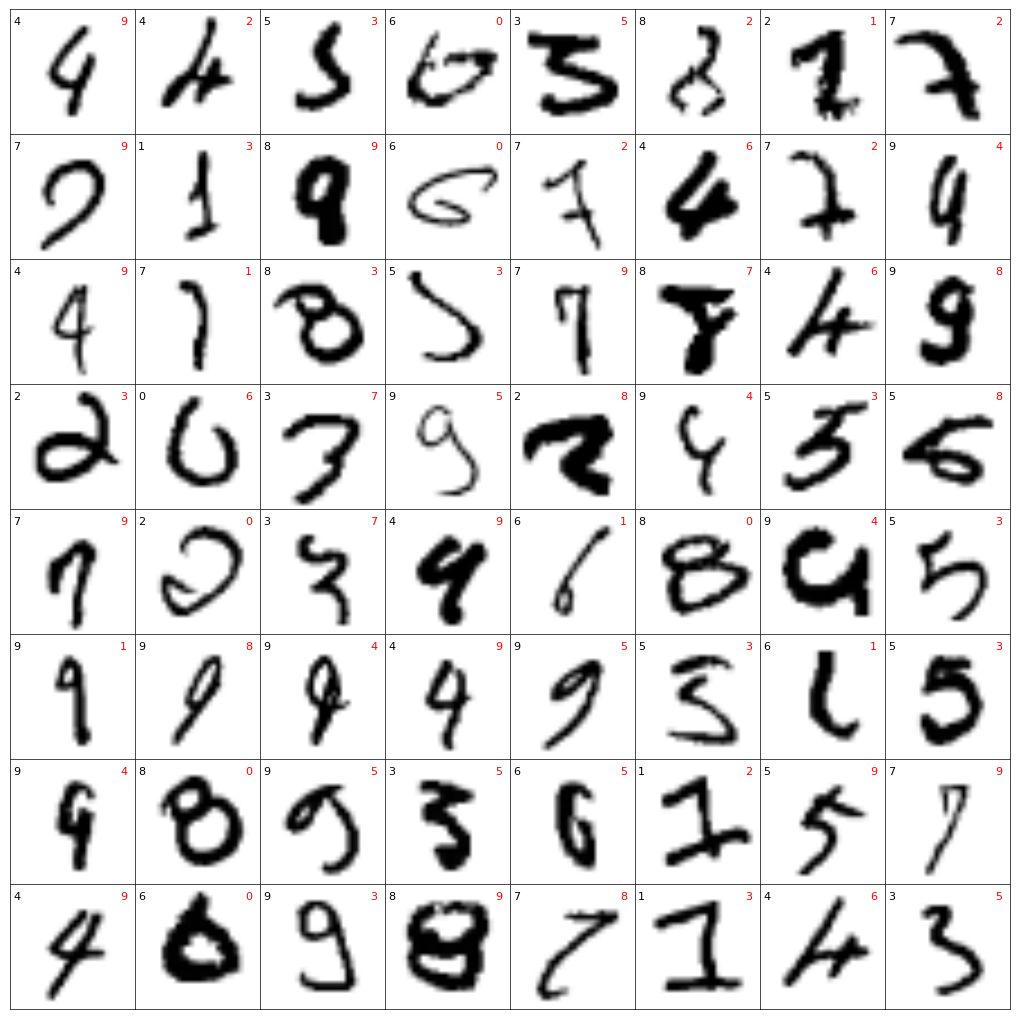

In [12]:
images = mnist.test.images
labels = np.argmax(mnist.test.labels, 1)
lr_index_to_render = 0
preds = predictions[lr_index_to_render]
incorrects = np.not_equal(labels, preds)
plot_batch_images(images[incorrects], labels[incorrects], preds[incorrects], 64)

In [18]:
print('Total number of incorrect predictions is: {}'.format(len(incorrects[incorrects == True])))
print('The best accuracy: {}'.format(test_accuracy[lr_index_to_render][-5:]))

Total number of incorrect predictions is: 118
The best accuracy: [ 0.98810005  0.98770005  0.98820019  0.98810017  0.98820007]
